###  Islands: Generalized Linear Models - Chapter 5

[Back to Main Page](0_main_page.ipynb)

<br>

<h1> <center> Multinomial Logistic Regression </center> </h1>  

## Context



## Model

[Interested in the probability of events in various categories]

$ \large \hat{P}_{(y_{i} = 0)} = \hat\pi_{0i}$ 

$ \large \hat{P}_{(y_{i} = 1)} = \hat\pi_{1i} $

$ \dots $

$ \large \hat{P}_{(y_{i} = m)} = \hat\pi_{mi} $
[Show whole prediction equation]

$ \Large \hat{y}_{i} = ln\left(\frac{Pr(Y=j)}{Pr(Y=\text{Reference})}\right)_{i} = b_{0}^{j} + b_{1}^{j}x_{1i} + ... b_{k}^{j}x_{ki}  $

[Show individual prediction equations]

[Show matrix]

[Show matrix form of prediction equation]


## Parameter estimates

The coefficients ($b_0, b_k$) can be estimated by...

For a single score:

[single score value here]

[illustration of different types of normal distribution here]

The predicted probability of falling into class $j$ for observation $i$:

$ \large \hat\pi_{ji} = \frac{e^{\hat{y_ji}}}{1 + \sum{e^{\hat{y_{ji}}}}} $

For the reference category:

$ \large \hat\pi_{mi} = \frac{1}{1 + \sum{e^{\hat{y_{ji}}}}} = 1 - \sum \hat\pi_{ji} $

The model gets its parameters, by maximizing:

$ \large {\operatorname{arg max}} \prod \hat\pi_{0i}^{\text{indicator}_{0i}} \hat\pi_{1i}^{\text{indicator}_{1i}} ...\hat\pi_{ji}^{\text{indicator}_{ji}} $

[illustration of fitting several normal distribution around the regression line here]


Equivalently, by minimizing (has the same effect, but easier for a computer to work with):

[full log like here (with all j), show that because of dummies it reduces to:]

$ \large {\operatorname{arg min}} - \sum \text{indicator}_{ji} * \large[ \hat{y_{ji}}  - \ln(1 + \sum{e^{\hat{y_{ji}}}} )\large]$

[Explain how this works at the level of individual predictions]

## Implementation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import islands_GLM

islands_GLM.r_ify()

C:\Users\rushpz\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
# religion names from https://www.fantasynamegenerators.com/religion-names.php

pop_size = 100

religions = np.array(['Healers of Symmetry', 'Communion of the Sacrifice', 'Children of the Titans'])

income = np.random.gamma(1, size = pop_size) * 100

religion = np.array([])
bio_sex = np.array([])

for inc in income:
    
    if inc < np.median(income):
        
        religion = np.append(religion, np.random.choice(['Healers of Symmetry', 
                                                         'Communion of the Sacrifice', 
                                                         'Children of the Titans'], 
                                                       p = [3.5/6, 2.4/6, 0.1/6]))
        bio_sex = np.append(bio_sex, np.random.choice(['male', 'female'], p = [0.7, 0.3]))
        
    elif inc >= np.median(income):
        
        religion = np.append(religion, np.random.choice(['Healers of Symmetry', 
                                                         'Communion of the Sacrifice', 
                                                         'Children of the Titans'], 
                                                       p = [0.5/6, 2/6, 3.5/6]))
        bio_sex = np.append(bio_sex, np.random.choice(['male', 'female'], p = [0.3, 0.7]))
        
        
        
        
df = pd.DataFrame({'income': income.astype('int'), 'religion': religion, 'biological_sex': bio_sex})

df

,income,religion,biological_sex
0,46,Healers of Symmetry,female
1,309,Children of the Titans,female
2,25,Healers of Symmetry,male
3,51,Communion of the Sacrifice,male
4,227,Communion of the Sacrifice,male
...,...,...,...
95,255,Communion of the Sacrifice,female
96,23,Communion of the Sacrifice,male
97,4,Communion of the Sacrifice,male
98,419,Children of the Titans,male


In [3]:
df['religion_dummy'] =  df['religion'].replace(df['religion'].unique(), np.arange(len(df['religion'].unique())))
df['biological_sex_dummy'] =  df['biological_sex'].replace(df['biological_sex'].unique(), np.arange(len(df['biological_sex'].unique())))
df

,income,religion,biological_sex,religion_dummy,biological_sex_dummy
0,46,Healers of Symmetry,female,0,0
1,309,Children of the Titans,female,1,0
2,25,Healers of Symmetry,male,0,1
3,51,Communion of the Sacrifice,male,2,1
4,227,Communion of the Sacrifice,male,2,1
...,...,...,...,...,...
95,255,Communion of the Sacrifice,female,2,0
96,23,Communion of the Sacrifice,male,2,1
97,4,Communion of the Sacrifice,male,2,1
98,419,Children of the Titans,male,1,1


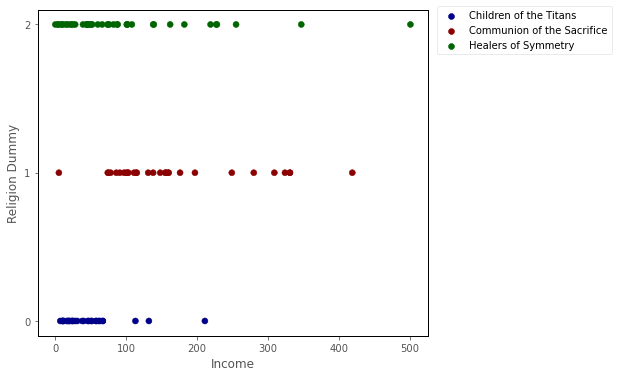

In [4]:
relig_color = {0: 'darkblue',
              1: 'darkred',
              2: 'darkgreen'}

fig, ax = plt.subplots()
ax.scatter(df['income'], df['religion_dummy'] , c = df['religion_dummy'].map(relig_color))
ax.set_yticks([0,1,2])
ax.set_ylabel('Religion Dummy')
ax.set_xlabel('Income')
ax.scatter([], [], color = 'darkblue', label = 'Children of the Titans' )
ax.scatter([], [],  color = 'darkred', label = 'Communion of the Sacrifice')
ax.scatter([], [],  color = 'darkgreen', label = 'Healers of Symmetry')
plt.legend(bbox_to_anchor = (1.01,1.025))
plt.show()

In [5]:
def mnlogit_cost(intercept_and_slope, x, y):

    intercept_1, slope_1, intercept_2, slope_2, = intercept_and_slope
    
    predicted_log_odds_1 = intercept_1 + slope_1 * x
    predicted_log_odds_2 = intercept_2 + slope_2 * x

    y_dummies = pd.get_dummies(y)
     
    log_likelihood = np.sum(y_dummies[1].values * predicted_log_odds_1 + y_dummies[2].values * predicted_log_odds_2 - np.log(1 + np.exp(predicted_log_odds_1) +  np.exp(predicted_log_odds_2)))

    return -log_likelihood

In [6]:
mnlogit_cost([.1,.1,.1,.1], df['income'], df['religion_dummy'])

211.06570845612293

In [7]:
from scipy.optimize import minimize

minimize(mnlogit_cost, [1,1,1,1], args =(df['income'], df['religion_dummy']), tol = 1e-16)

      fun: 94.50430457912225
 hess_inv: array([[ 2.48940226e-01, -2.17856416e-03,  1.20298563e-01,
        -1.53255174e-03],
       [-2.17856416e-03,  3.26124375e-05, -1.44951806e-03,
         2.74723350e-05],
       [ 1.20298563e-01, -1.44951806e-03,  1.65510692e-01,
        -1.68283997e-03],
       [-1.53255174e-03,  2.74723350e-05, -1.68283997e-03,
         2.93140974e-05]])
      jac: array([ 3.14712524e-05,  3.98826599e-03, -5.91278076e-05, -1.17874146e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 419
      nit: 13
     njev: 68
   status: 2
  success: False
        x: array([-1.83782992,  0.02169444, -0.58367868,  0.01461716])

In [8]:
mod = sm.MNLogit(df['religion_dummy'], sm.add_constant(df['income'])).fit()

mod.summary()

Optimization terminated successfully.
         Current function value: 0.945043
         Iterations 7


C:\Users\rushpz\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:         religion_dummy   No. Observations:                  100
Model:                        MNLogit   Df Residuals:                       96
Method:                           MLE   Df Model:                            2
Date:                Fri, 17 Jun 2022   Pseudo R-squ.:                  0.1268
Time:                        15:59:17   Log-Likelihood:                -94.504
converged:                       True   LL-Null:                       -108.23
Covariance Type:            nonrobust   LLR p-value:                 1.092e-06
====================================================================================
religion_dummy=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.8378      0.495     -3.711      0.000      -2.809      -0.867
income               0.0217      0.006      3.812      0.000       0.011       0.033
------------------------------------------------------------------------------------
religion_dummy=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.5837      0.398     -1.465      0.143      -1.364       0.197
income               0.0146      0.005      2.693      0.007       0.004       0.025
====================================================================================
"""

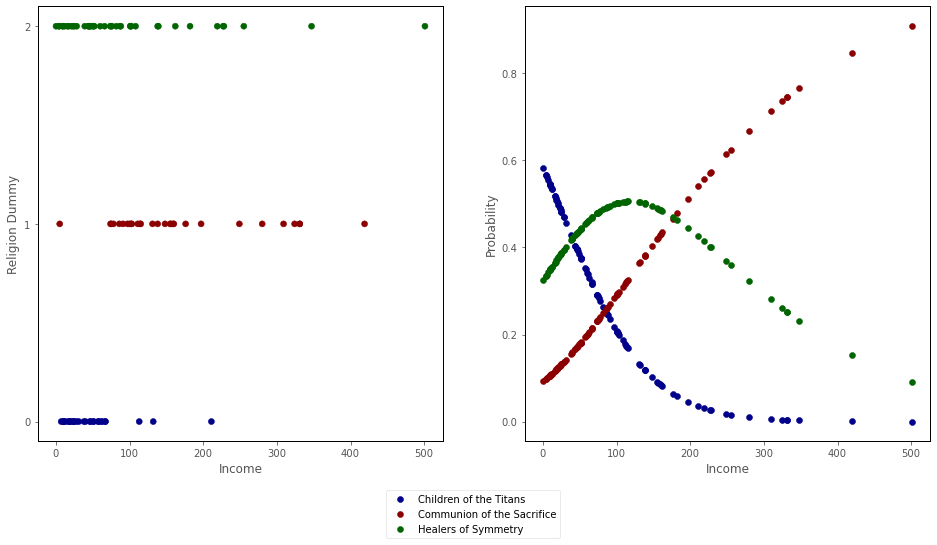

In [9]:
log_odds_predictions_1 = mod.params.loc['const', 0] +  mod.params.loc['income', 0] * df['income']
log_odds_predictions_2 = mod.params.loc['const', 1] +  mod.params.loc['income', 1] * df['income']

probability_predictions_1 = np.exp(log_odds_predictions_1)/(1 + np.exp(log_odds_predictions_1) + np.exp(log_odds_predictions_2))

probability_predictions_2 = np.exp(log_odds_predictions_2)/(1 + np.exp(log_odds_predictions_1) + np.exp(log_odds_predictions_2))

probability_predictions_0 = 1 - probability_predictions_1 - probability_predictions_2

relig_color = {0: 'darkblue',
              1: 'darkred',
              2: 'darkgreen'}

fig, ax = plt.subplots(nrows =1, ncols=2, figsize = (16, 8))
ax[0].scatter(df['income'], df['religion_dummy'] , c = df['religion_dummy'].map(relig_color))
ax[0].set_yticks([0,1,2])
ax[0].set_ylabel('Religion Dummy')
ax[0].set_xlabel('Income')
ax[1].scatter(df['income'], probability_predictions_0, color = 'darkblue', label = 'Children of the Titans' )
ax[1].scatter(df['income'], probability_predictions_1, color = 'darkred', label = 'Communion of the Sacrifice')
ax[1].scatter(df['income'], probability_predictions_2, color = 'darkgreen', label = 'Healers of Symmetry')
ax[1].set_ylabel('Probability')
ax[1].set_xlabel('Income')
plt.legend(bbox_to_anchor = (0.1,-0.1))
plt.show()

## Multi-predictor multionomial logistic regression

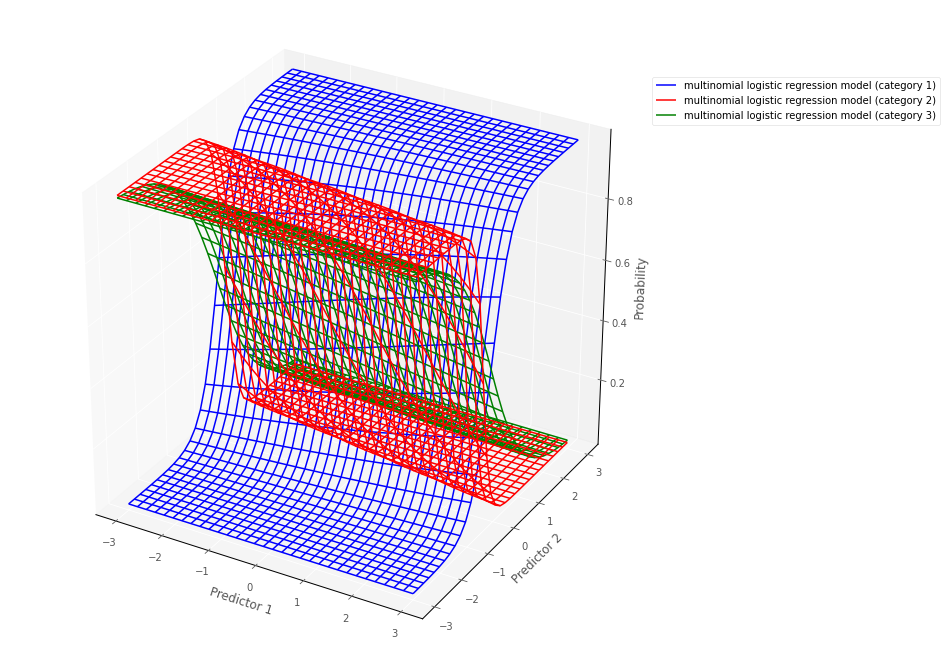

In [10]:
# show how multinomial logistic regression works in multiple dimensions

# figure out how to generate multiple

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

x_slope = 0.2
y_slope = 3
 
x = np.outer(np.linspace(-3, 3, 32), np.ones(32))
y = x.copy().T # transpose
lin_pop_z = x_slope*x + y_slope*y
z = np.exp(lin_pop_z)/(1 + np.exp(lin_pop_z))

x_slope2 = -1
y_slope2 = -6
 

lin_pop_z2 = x_slope2*x + y_slope2*y
z2 = np.exp(lin_pop_z2)/(1 + np.exp(lin_pop_z2))

x_slope3 = -0.1
y_slope3 = -1.5
 

lin_pop_z3 = x_slope3*x + y_slope3*y
z3 = np.exp(lin_pop_z3)/(1 + np.exp(lin_pop_z3))



from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize = (12,12))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_wireframe(x,y,z, color = 'blue', label = 'multinomial logistic regression model (category 1)')
ax1.plot_wireframe(x,y,z2, color = 'red', label = 'multinomial logistic regression model (category 2)')
ax1.plot_wireframe(x,y,z3, color = 'green', label = 'multinomial logistic regression model (category 3)')
plt.xlabel('Predictor 1')
plt.ylabel('Predictor 2')
ax1.set_zlabel('Probability')
plt.legend(bbox_to_anchor = (1.4,0.9))
plt.show()

In [11]:
mod = sm.MNLogit(df['religion_dummy'], sm.add_constant(df[['income', 'biological_sex_dummy']])).fit()

mod.summary()

Optimization terminated successfully.
         Current function value: 0.943151
         Iterations 7


C:\Users\rushpz\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:         religion_dummy   No. Observations:                  100
Model:                        MNLogit   Df Residuals:                       94
Method:                           MLE   Df Model:                            4
Date:                Fri, 17 Jun 2022   Pseudo R-squ.:                  0.1286
Time:                        15:59:18   Log-Likelihood:                -94.315
converged:                       True   LL-Null:                       -108.23
Covariance Type:            nonrobust   LLR p-value:                 1.348e-05
========================================================================================
    religion_dummy=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.0318      0.649     -3.133      0.002      -3.303      -0.761
income                   0.0228      0.006      3.692      0.000       0.011       0.035
biological_sex_dummy     0.2536      0.633      0.400      0.689      -0.987       1.495
----------------------------------------------------------------------------------------
    religion_dummy=2       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.8187      0.559     -1.465      0.143      -1.914       0.277
income                   0.0158      0.006      2.663      0.008       0.004       0.027
biological_sex_dummy     0.3298      0.540      0.611      0.541      -0.728       1.387
========================================================================================
"""

In [23]:
def three_D_model_plot_multinomial(x_name, y_name, z_name, intercept, x_slope, y_slope,  intercept_2, x_slope_2, y_slope_2, 
                                   df, model_name):
    
    x = np.linspace(np.min(df[x_name]), np.max(df[x_name]), 8)
    y = np.linspace(np.min(df[y_name]), np.max(df[y_name]), 8)
    x, y = np.meshgrid(x, y)

        
    
    z = (np.exp(intercept + x_slope * x.ravel() + y_slope * y.ravel()))/(1 + np.exp(intercept + x_slope * x.ravel() + y_slope * y.ravel()) + np.exp(intercept_2 + x_slope_2 * x.ravel() + y_slope_2 * y.ravel()))
    z2 = (np.exp(intercept_2 + x_slope_2 * x.ravel() + y_slope_2 * y.ravel()))/(1 + np.exp(intercept + x_slope * x.ravel() + y_slope * y.ravel()) + np.exp(intercept_2 + x_slope_2 * x.ravel() + y_slope_2 * y.ravel()))
    z3 = 1 - z - z2
    
    fig = plt.figure(figsize = (16, 8))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot_wireframe(x, y,
                    z.reshape(x.shape), label = model_name+' (Communion of the Sacrifice)', color = 'red', alpha = 0.5)
    ax1.plot_wireframe(x, y,
                    z2.reshape(x.shape), label = model_name+ ' (Healers of Symmetry)', color = 'green', alpha = 0.5)
    ax1.plot_wireframe(x, y,
                    z3.reshape(x.shape), label = model_name+ ' (Children of the Titans)', color = 'blue')
    ax1.view_init(azim = 30)
    ax1.set_yticks([0,1])
    ax1.set_zticks([0,1])
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    ax1.set_zlabel('Probability')
    ax1.legend(bbox_to_anchor = (1,0))
 
    
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(df[x_name], df[y_name], df[z_name], c = df['religion_dummy'].map(relig_color))
    ax2.view_init(azim = 30)
    ax2.set_yticks([0,1])
    ax2.set_zticks([0,1, 2])
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    ax2.set_zlabel(z_name)
    plt.show()

In [13]:
intercept_1, income_slope_1, biological_sex_dummy_slope_1 = mod.params[0][:]
intercept_2, income_slope_2, biological_sex_dummy_slope_2 = mod.params[1][:]

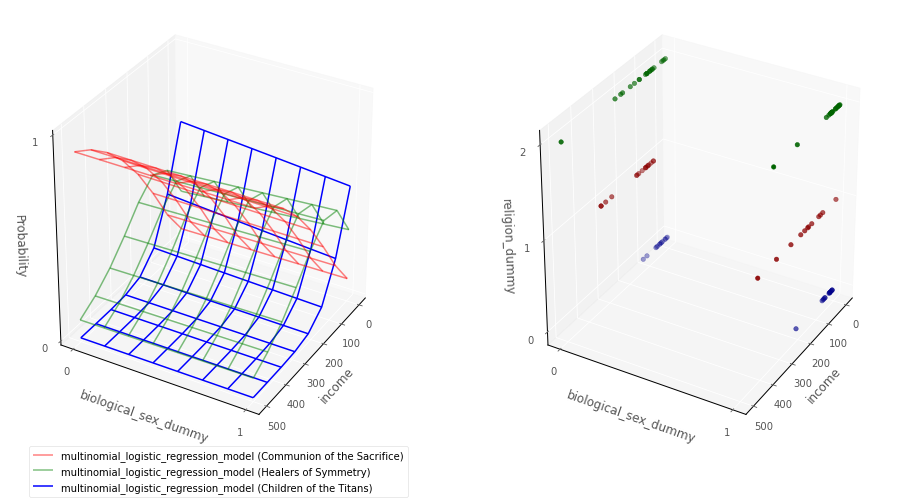

In [24]:
three_D_model_plot_multinomial('income', 'biological_sex_dummy', 
                   'religion_dummy', intercept_1, income_slope_1, biological_sex_dummy_slope_1, intercept_2, income_slope_2, biological_sex_dummy_slope_2,
                  df, 'multinomial_logistic_regression_model')

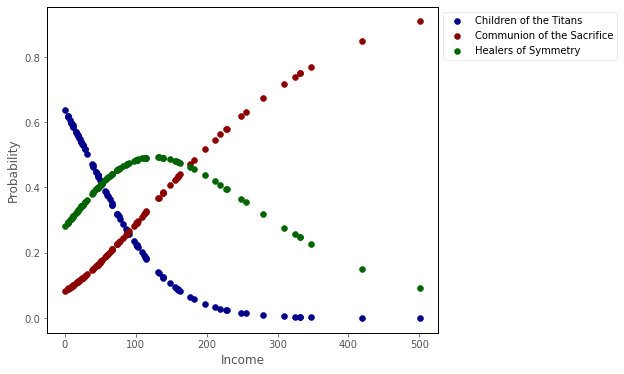

In [15]:
# easier to see pattern on this plot

log_odds_predictions_1 = mod.params.loc['const', 0] +  mod.params.loc['income', 0] * df['income']
log_odds_predictions_2 = mod.params.loc['const', 1] +  mod.params.loc['income', 1] * df['income']

probability_predictions_1 = np.exp(log_odds_predictions_1)/(1 + np.exp(log_odds_predictions_1) + np.exp(log_odds_predictions_2))

probability_predictions_2 = np.exp(log_odds_predictions_2)/(1 + np.exp(log_odds_predictions_1) + np.exp(log_odds_predictions_2))

probability_predictions_0 = 1 - probability_predictions_1 - probability_predictions_2

fig, ax = plt.subplots()
ax.scatter(df['income'], probability_predictions_0, color = 'darkblue', label = 'Children of the Titans' )
ax.scatter(df['income'],probability_predictions_1, color = 'darkred', label = 'Communion of the Sacrifice')
ax.scatter(df['income'], probability_predictions_2, color = 'darkgreen', label = 'Healers of Symmetry')
ax.set_ylabel('Probability')
ax.set_xlabel('Income')
plt.legend(bbox_to_anchor = (1,1))
plt.show()

## Interpretation (multiple predictors)

The coefficient of each predictor tells us the predicted difference in the outcome variable scores for two observations which differed *only* by a one unit score in that predictor. E.g. which had the same score on all other predictors.

The intercept tells us the predicted score on the outcome variable for an observation whose score on all other predictors was 0. 

## Statistical interaction in Multinomial Logistic Regression

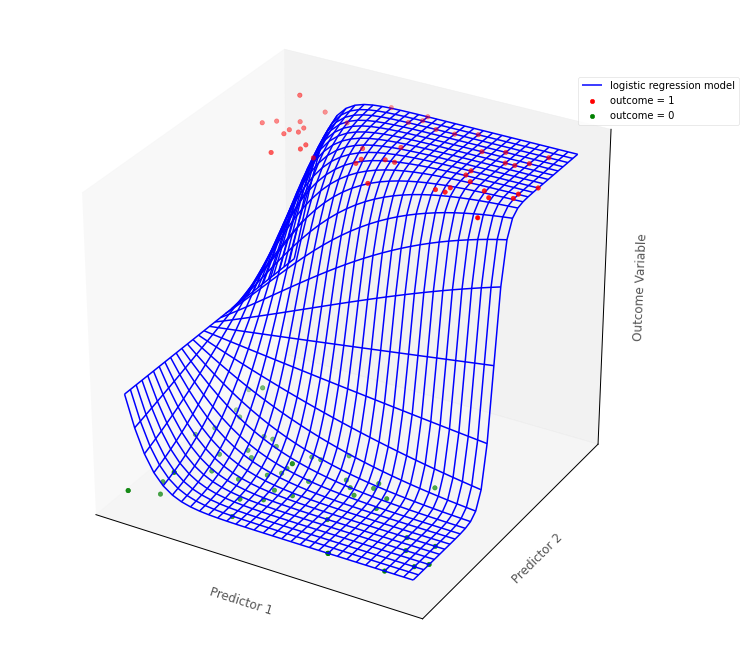

In [17]:
x_slope = 0.2
y_slope = 3
 
x = np.outer(np.linspace(-3, 3, 32), np.ones(32))
y = x.copy().T # transpose
lin_pop_z = x_slope*x + y_slope*y + 1*x*y
z = np.exp(lin_pop_z)/(1 + np.exp(lin_pop_z))

data_x = np.random.choice(np.linspace(-3, 3, 32), size = 100)
data_y = np.random.choice(np.linspace(-3, 3, 32), size = 100)
lin_pred = x_slope*data_x + y_slope*data_y + 1*data_x*data_y + np.random.normal(0, 0.3, size = 100)
data_z = (np.exp(lin_pred))/(1 + np.exp(lin_pred))
data_z = np.where(data_z >= 0.5, 1, 0)

from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize = (12,12))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_wireframe(x,y,z, color = 'blue', label = 'logistic regression model')
ax1.scatter(data_x[data_z >= 0.5], data_y[data_z >= 0.5], data_z[data_z >= 0.5], color = 'red', label = 'outcome = 1')
ax1.scatter(data_x[data_z < 0.5], data_y[data_z < 0.5], data_z[data_z < 0.5], color = 'green', label = 'outcome = 0'  )
ax1.set_zticks([0,1])
plt.xlabel('Predictor 1')
plt.ylabel('Predictor 2')
ax1.set_zlabel('Outcome Variable')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
plt.legend(bbox_to_anchor = (1.1,0.9))
plt.show()

## Other Chapters

1. [What are Generalized Linear Models?](1_generalized_linear_models.ipynb)
2. [Linear Regression](2_linear_regression.ipynb)
3. [Poisson Regression](3_poisson_regression.ipynb)
4. [Binary Logistic Regression](4_binary_logistic_regression.ipynb)
5. [Multinomial Logistic Regression](5_multinomial_logistic_regression.ipynb)

***
By [pxr687](99_about_the_author.ipynb) 